In [1]:
import torch
from augerino import datasets, models
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from augerino.models.e2_steerable import C8SteerableCNN, SmallE2
from smallnet import smallnet

In [2]:
use_cuda = torch.cuda.is_available()

In [3]:
checkpt_path = "./saved-outputs/"
ncopies = 12

In [4]:
net = smallnet(in_channels=1,num_targets=10)
augerino = models.UniformAug()
low_model = models.AugAveragedModel(net, augerino,ncopies=ncopies)

net = smallnet(in_channels=1,num_targets=10)
augerino = models.UniformAug()
mid_model = models.AugAveragedModel(net, augerino,ncopies=ncopies)

net = smallnet(in_channels=1,num_targets=10)
augerino = models.UniformAug()
high_model = models.AugAveragedModel(net, augerino,ncopies=ncopies)

In [5]:
low_model.load_state_dict(torch.load(checkpt_path + "model0.01.pt"))
mid_model.load_state_dict(torch.load(checkpt_path + "model0.05.pt"))
high_model.load_state_dict(torch.load(checkpt_path + "model0.1.pt"))

<All keys matched successfully>

In [6]:
net = smallnet(in_channels=1,num_targets=10)
augerino = models.UniformAug()
init_model = models.AugAveragedModel(net, augerino,ncopies=ncopies)
init_model.load_state_dict(torch.load(checkpt_path + "model0.01_init.pt"))

<All keys matched successfully>

In [7]:
e2_model = SmallE2(channel_in=1, n_classes=10, rot_n=10)
e2_model.load_state_dict(torch.load("./saved-outputs/e2_epoch200.pt", map_location='cpu'))

/home/greg_b/e2cnn/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:61: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:20.)
  sampled_basis = sampled_basis[mask, ...]


<All keys matched successfully>

In [8]:
dataset = datasets.RotMNIST("~/datasets/", train=True)
trainloader = DataLoader(dataset, batch_size=128)


/home/greg_b/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/greg_b/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [9]:
img, lab = next(iter(trainloader))
init_aug = init_model.aug(img)
end_aug = mid_model.aug(img)

## Let's Mess Around With Rotating Inputs

In [10]:
dataset = datasets.RotMNIST("~/datasets/", train=False)
testloader = DataLoader(dataset, batch_size=128)
testimg, testlab =next(iter(trainloader))

In [11]:
torch.where(testlab==4)

(tensor([  2,   9,  20,  26,  53,  58,  60,  61,  64,  89,  92, 115, 127]),)

In [26]:
ind = 64

In [27]:
n_ang = 50
angles = torch.linspace(-np.pi, np.pi, n_ang)

four = testimg[ind, ::].unsqueeze(0)
batch_four = torch.cat(n_ang * [four])


with torch.no_grad():
    # Build affine matrices for random translation of each image
    affineMatrices = torch.zeros(n_ang,2,3)
    affineMatrices[:,0,0] = angles.cos()
    affineMatrices[:,1,1] = angles.cos()
    affineMatrices[:,0,1] = angles.sin()
    affineMatrices[:,1,0] = -angles.sin()

    flowgrid = F.affine_grid(affineMatrices, size = batch_four.size())
    
    rot_four = F.grid_sample(batch_four, flowgrid)
    

/home/greg_b/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/greg_b/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [28]:
low_model.eval();
high_model.eval();
mid_model.eval();
e2_model.eval();

In [29]:
# low_model.train();
# high_model.train();
# mid_model.train();
# e2_model.train();

In [30]:
with torch.no_grad():
    low_preds = low_model(rot_four)
    high_preds = high_model(rot_four)
    mid_preds = mid_model(rot_four)

In [31]:
with torch.no_grad():
    e2_preds = e2_model(rot_four)

In [32]:
sftmx = torch.nn.Softmax(-1)
low_probs = sftmx(low_preds)
high_probs = sftmx(high_preds)
mid_probs = sftmx(mid_preds)
e2_probs = sftmx(e2_preds)

In [33]:
tick_pts = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
tick_labs = [r"-$\pi$", r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$']

#### distribution plot

In [34]:
softplus = torch.nn.Softplus()
test_pts = torch.linspace(-2, 2)

In [35]:
def get_density(test_pts, width):
    dist = torch.distributions.Uniform(-width/2., width/2.)
    dens = dist.log_prob(test_pts).exp().detach()
    return dens

In [36]:
# init_dens = get_density(test_pts, softplus(torch.tensor(-1.)))
# high_dens = get_density(test_pts, high_logger[500:501]['width2'].values[0])
# mid_dens = get_density(test_pts, mid_logger[500:501]['width2'].values[0])
# low_dens = get_density(test_pts, low_logger[500:501]['width2'].values[0])

In [37]:
init_dens = get_density(test_pts, softplus(torch.tensor(-1.)))
width = min(softplus(high_model.aug.width[2]), 2*np.pi)
high_dens = get_density(test_pts, width)
width = min(softplus(mid_model.aug.width[2]), 2*np.pi)
mid_dens = get_density(test_pts, width)
width = min(softplus(low_model.aug.width[2]), 2*np.pi)
low_dens = get_density(test_pts, width)

## Plot it all

In [38]:
def plot_img(fig, img, i, j, label):
    ax = plt.Subplot(fig, inner[i,j])
    ax.imshow(img, cmap="Greys", interpolation='nearest')
    ax.set_title(label, fontsize=ax_fs+4, y=-0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

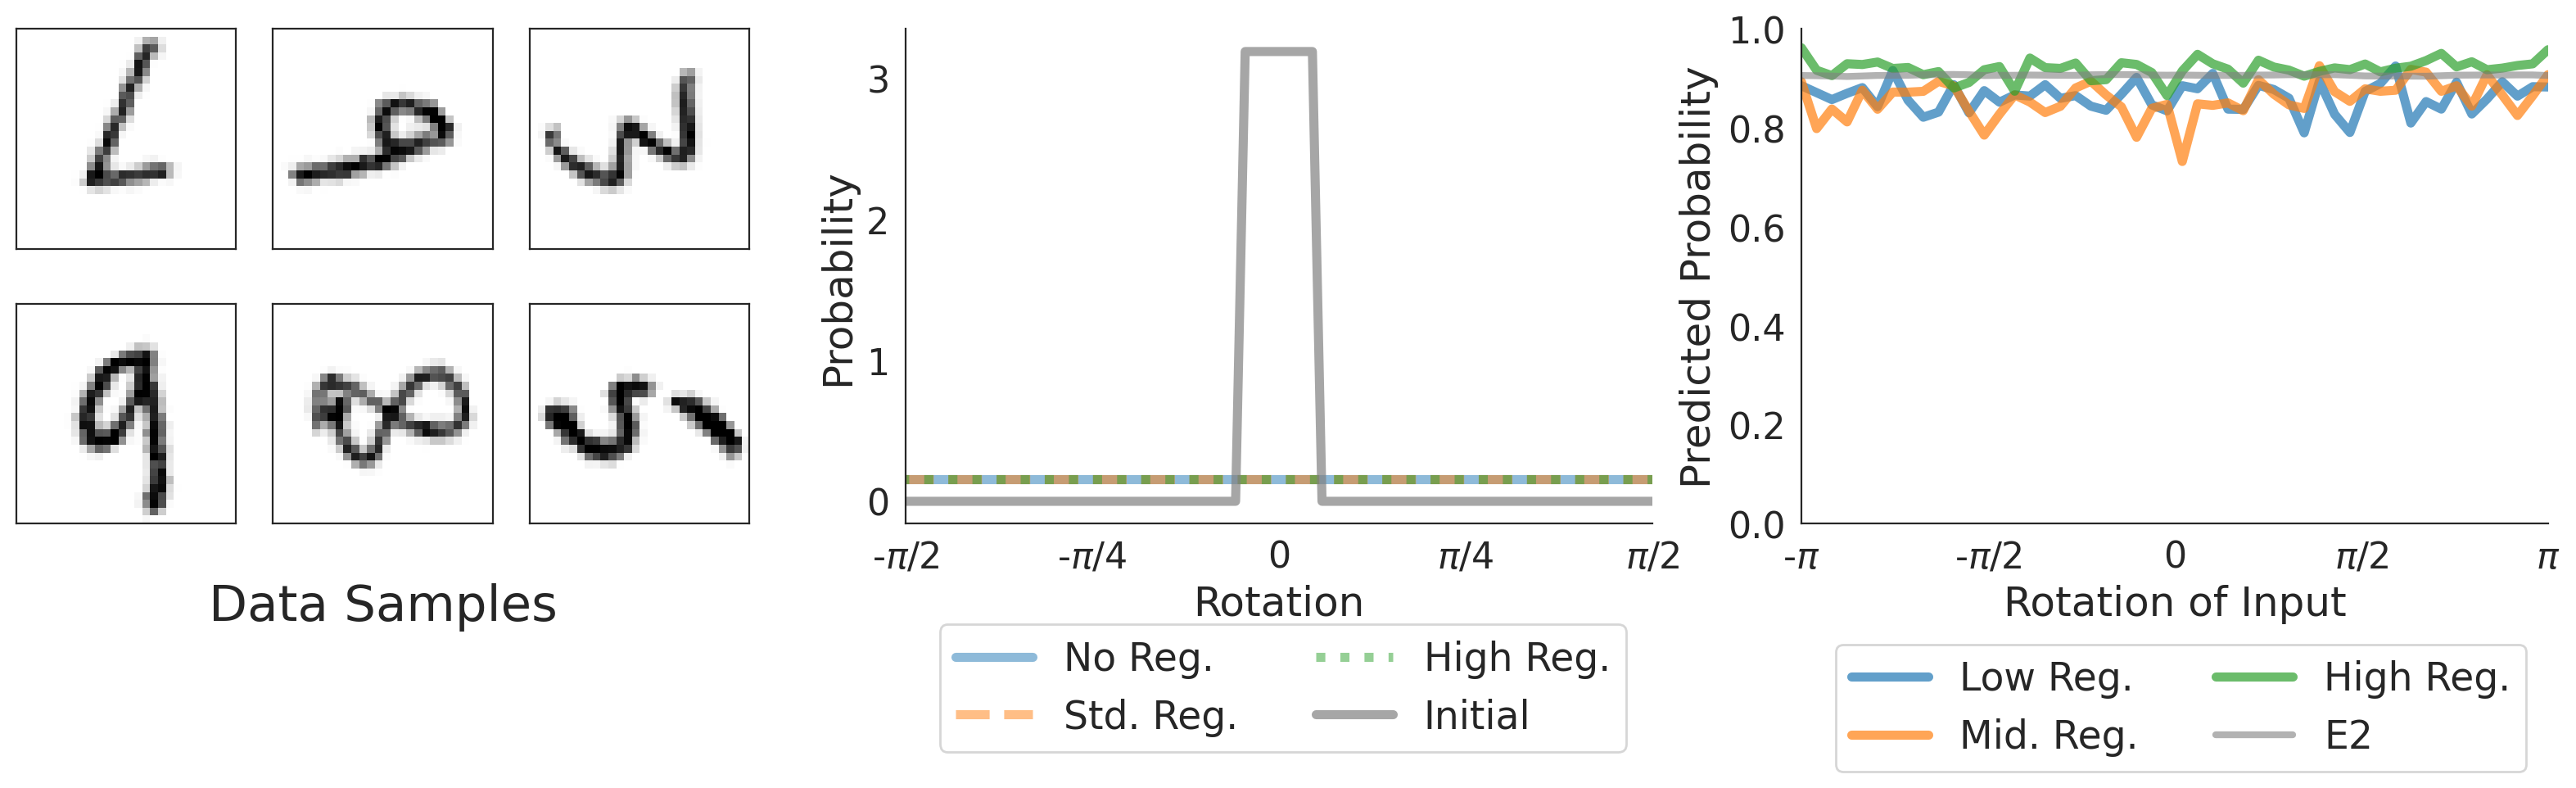

In [39]:
import matplotlib.gridspec as gridspec
sns.set_style("white")
fig = plt.figure(figsize=(20, 4), dpi=200)
outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.2)
alpha=0.5
ax_fs=18
lwd=4.
## plot mario and iggy

inner = gridspec.GridSpecFromSubplotSpec(2, 3,
                subplot_spec=outer[0], wspace=0.1, hspace=0.25)
ind=42
plot_img(fig, img[ind, 0, ::].cpu().detach(),
        0, 0, "")
plot_img(fig, img[ind+1, 0, ::].cpu().detach(),
        0, 1, "")
plot_img(fig, img[ind+2, 0, ::].cpu().detach(),
        0, 2, "")
plot_img(fig, img[ind+3, 0, ::].cpu().detach(),
        1, 0, "")
plot_img(fig, img[ind+4, 0, ::].cpu().detach(),
        1, 1, "Data Samples")
plot_img(fig, img[ind+5, 0, ::].cpu().detach(),
        1, 2, "")
ax = plt.Subplot(fig, inner[1, 1])
        
## Plot Learned Distribution
inner = gridspec.GridSpecFromSubplotSpec(1,1,
                    subplot_spec=outer[1], wspace=0.1, hspace=0.1)
ax = plt.Subplot(fig, inner[0])
ax.plot(test_pts, low_dens.detach().cpu(), linewidth=lwd, label="No Reg.",
        alpha=alpha, linestyle="-")
ax.plot(test_pts, mid_dens.detach().cpu(), linewidth=lwd, label="Std. Reg.",
        alpha=alpha, linestyle="--")
ax.plot(test_pts, high_dens.detach().cpu(), linewidth=lwd, label="High Reg.",
        alpha=alpha, linestyle=":")
ax.plot(test_pts, init_dens.detach(), linewidth=lwd, label="Initial", color='gray', alpha=0.7)
ax.legend(loc='lower left', fontsize=ax_fs-1, ncol=2,
           bbox_to_anchor=(0.02, -0.5))
ax.set_xlabel("Rotation", fontsize=ax_fs)
ax.set_ylabel("Probability", fontsize=ax_fs)
tick_pts = [-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2]
tick_labs = [r"-$\pi$/2", r'-$\pi$/4', '0', r'$\pi$/4', r'$\pi$/2']
ax.set_xticks(tick_pts)
ax.set_xticklabels(tick_labs)
ax.set_xlim(-np.pi/2, np.pi/2)
ax.tick_params("both", labelsize=ax_fs-2)
sns.despine(ax=ax)
fig.add_subplot(ax)


inner = gridspec.GridSpecFromSubplotSpec(1,1,
                    subplot_spec=outer[2], wspace=0.1, hspace=0.1)
ax = plt.Subplot(fig, inner[0])
alpha=0.7
num=4
lwd=4
ax.plot(angles, low_probs[:, num].detach().cpu(), linewidth=lwd, label="Low Reg.",
        alpha=alpha, linestyle="-")
ax.plot(angles, mid_probs[:, num].detach().cpu(), linewidth=lwd, label="Mid. Reg.",
        alpha=alpha, linestyle="-")
ax.plot(angles, high_probs[:, num].detach().cpu(), linewidth=lwd, label="High Reg.",
        alpha=alpha, linestyle="-")
ax.plot(angles, e2_probs[:, num].detach().cpu(), linewidth=3, label="E2",
        color='gray', alpha=0.6)
ax.set_ylim(0.0, 1.001)
ax.set_xlabel("Rotation of Input", fontsize=ax_fs)
ax.set_ylabel("Predicted Probability", fontsize=ax_fs)
tick_pts = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
tick_labs = [r"-$\pi$", r'-$\pi$/2', '0', r'$\pi$/2', r'$\pi$']
ax.tick_params("both", labelsize=ax_fs-2)
ax.set_xticks(tick_pts)
ax.set_xticklabels(tick_labs)

# ax.set_yticks([0.98, 0.99, 1.])
ax.set_xlim(-np.pi, np.pi)
ax.legend(loc="lower left", fontsize=ax_fs-1, ncol=2,
           bbox_to_anchor=(0.02, -0.54))
sns.despine(ax=ax)
fig.add_subplot(ax)
plt.savefig("./rotmnist_full.pdf", bbox_inches='tight')